In [63]:
# ============================================================
# Notebook setup
# ============================================================

%reload_ext autoreload
%autoreload 2

# Control figure size
interactive_figures = False
if interactive_figures:
    # Normal behavior
    %matplotlib widget
    figsize=(9, 3)
else:
    # PDF export behavior
    figsize=(14, 5)

from util import cst
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers, callbacks
#from tensorflow_probability import distributions
from sklearn.metrics import r2_score, mean_squared_error
from tensorflow.keras import backend as k

# Load data
data_folder = '/app/data'
data = cst.load_cmapss_data(data_folder)

# Identify input columns
dt_in = list(data.columns[3:-1])

# Domain Knowledge Injection via SBR

## Scarce Labels in RUL Predictions

**In our RUL use case we had access to many run-to-failure experiments**

In practice, this is _seldom the case_

* Run-to-failure experiments are time consuming
* They may not be viable for large and complex machines
* Typically, _only a few runs_ are available

**However, data about _normal_ operation may still be abundant**

* This may come from test runs, installed machines, etc.
* It looks exactly like the input data for our RUL prediction model
* ...And it will still show sign of component wear

However, _the true RUL value in this case will be unknown_

> **Can we still take advantage of this data?**

## Domain Knowledge in Machine Learning

**We can take an _anomaly detection_ approach**

* We can use an AE or a density estimator to generate an _anomaly signal_
* Then we can _optimize a threshold_ based on the few run-to-failure experiments

This approach may work, but:

* Signals for different machines may grow at different rates
* ...Thus making the generalization difficult to achieve

**We can resort to autoencoders and use _semi-supervised learning_:**

* We train an autoencoder on the unsupervised data, then remove the decoder
* ...We replace them it with classification layers, trained on the supervised data

Another viable technique, but with _one drawback_

* Since the AE is trained for a task very different from RUL prediction
* ...There is no guarantee that the learned encoding is well suited for that


## Domain Knowledge in Machine Learning

**We will investigate here _a different approach_**

* We will use _domain knowledge_ to get information from the unsupervised data
* We will then inject such information in the model by means of _constraints_

**This approach introduces _a new source of information_**

* The domain knowledge may be provided by experts
* ...Or it may be a second, heterogeneous model (e.g. a physical model)

**In the remainder of the notebook**

* We will first address the problem using only the supervised information
* ...Then we will see how to use domain knowledge to exploit unsupervised data

**The approach is not limited to RUL prediction**

* The techniques we will see work for a wide variety of constraints 


# Our Baseline Approach

## Data Loading and Preparation

**Let's start by loading our old dataset**

We will focus once again on the FD004 data:

In [64]:
data_by_src = cst.split_by_field(data, field='src')
dt = data_by_src['train_FD004']
dt[dt_in] = dt[dt_in].astype(np.float32)

We then simulate the scarcity of run-to-failure experiments:

In [38]:
trs_ratio = 0.03 # Ratio of supervised experiments
tru_ratio = 0.75 # Ration of supervised and unsupervised data -> unsupervised data: 0.72

np.random.seed(42)
machines = dt.machine.unique()
np.random.shuffle(machines)

sep_trs = int(trs_ratio * len(machines))
sep_tru = int(tru_ratio * len(machines))

trs_mcn = list(machines[:sep_trs]) #prende machines con dati supervisionati
tru_mcn = list(machines[sep_trs:sep_tru]) #prende machines con dati non supervisionati
ts_mcn = list(machines[sep_tru:]) #restanti per test (25% del totale)

## Data Loading and Preparation

**Let's check how many machines we have in each group**

In [39]:
print(f'Num. machine: {len(trs_mcn)} (supervised), {len(tru_mcn)} (unsupervised), {len(ts_mcn)} (test)')

Num. machine: 7 (supervised), 179 (unsupervised), 63 (test)


We can then split the dataset according to this machine groups:

In [40]:
tr, ts = cst.partition_by_machine(dt, trs_mcn + tru_mcn)
trs, tru = cst.partition_by_machine(tr, trs_mcn)

Let's check the number of examples for each group:

In [41]:
print(f'Num. samples: {len(trs)} (supervised), {len(tru)} (unsupervised), {len(ts)} (test)')

Num. samples: 1376 (supervised), 44009 (unsupervised), 15864 (test)


## Data Loading and Preparation

**The we standardize the input data**

In [42]:
trmean = tr[dt_in].mean()
trstd = tr[dt_in].std().replace(to_replace=0, value=1) # handle static fields

ts_s = ts.copy()
ts_s[dt_in] = (ts_s[dt_in] - trmean) / trstd
tr_s = trs.copy()
tr_s[dt_in] = (tr_s[dt_in] - trmean) / trstd
trs_s = trs.copy()
trs_s[dt_in] = (trs_s[dt_in] - trmean) / trstd
tru_s = tru.copy()
tru_s[dt_in] = (tru_s[dt_in] - trmean) / trstd

**...And we normalize the RUL values**

In [43]:
trmaxrul = tr['rul'].max()

ts_s['rul'] = ts['rul'] / trmaxrul 
tr_s['rul'] = tr['rul'] / trmaxrul 
trs_s['rul'] = trs['rul'] / trmaxrul
tru_s['rul'] = tru['rul'] / trmaxrul

## MLP with Scarce Labels

**We can now train again our old MLP model**

In this case, we have wrapped its code in a class:

```python
class MLPRegressor(keras.Model):
    def __init__(self, input_shape, hidden=[]):
        super(MLPRegressor, self).__init__()
        self.lrs = [layers.Dense(h, activation='relu') for h in hidden]
        self.lrs.append(layers.Dense(1, activation='linear'))

    def call(self, data):
        x = data
        for layer in self.lrs: x = layer(x)
        return x
```

* We are subclassing `keras.Model` and inheriting all its methods
* The `__init__` method builds the necessary layers
* The `call` method computes the predictions

## MLP with Scarce Labels

### Task 1: train the model with only supervised data. We will experiment with different ratios of supervised data. 
In general, we expect that using higher ratios of supervised data will ensure better performances. However, if th emodel is too simple, it may incur in overfitting.

#### 1.1 100% of supervised data used for training

In [65]:
trs_ratio = 0.75 # Ratio of supervised experiments

np.random.seed(42)
machines = dt.machine.unique()
np.random.shuffle(machines)

sep_trs = int(trs_ratio * len(machines))

trs_mcn = list(machines[:sep_trs]) #prende machines con dati supervisionati
ts_mcn = list(machines[sep_trs:]) #restanti per test (25% del totale)

In [66]:
print(f'Num. machine: {len(trs_mcn)} (supervised), {len(ts_mcn)} (test)')

Num. machine: 186 (supervised), 63 (test)


In [67]:
trs, ts = cst.partition_by_machine(dt, trs_mcn)

In [68]:
print(f'Num. samples: {len(trs)} (supervised), {len(ts)} (test)')

Num. samples: 45385 (supervised), 15864 (test)


In [48]:
# standardize and normalize data
trmean = trs[dt_in].mean() #NB dt_in selects columns with sensors data
trstd = trs[dt_in].std().replace(to_replace=0, value=1) # handle static fields

ts_s = ts.copy()
ts_s[dt_in] = (ts_s[dt_in] - trmean) / trstd #standardize test set
tr_s = trs.copy()
tr_s[dt_in] = (tr_s[dt_in] - trmean) / trstd #standardize train set 

In [49]:
trmaxrul = trs['rul'].max()

ts_s['rul'] = ts['rul'] / trmaxrul 
trs_s['rul'] = trs['rul'] / trmaxrul

We train the model (seed 42)

In [50]:
np.random.seed(42)
nn = cst.MLPRegressor(input_shape=len(dt_in), hidden=[32, 32])
nn.compile(optimizer='Adam', loss='mse')
history = nn.fit(trs_s[dt_in], trs_s['rul'], validation_split=0.2, batch_size=32, epochs=20, verbose=1)

Epoch 1/20


35/35 [==============================] - 1s 5ms/step - loss: 0.0990 - val_loss: 0.0142
Epoch 2/20
35/35 [==============================] - 0s 4ms/step - loss: 0.0144 - val_loss: 0.0142
Epoch 3/20
35/35 [==============================] - 0s 3ms/step - loss: 0.0126 - val_loss: 0.0130
Epoch 4/20
35/35 [==============================] - 0s 3ms/step - loss: 0.0119 - val_loss: 0.0104
Epoch 5/20
35/35 [==============================] - 0s 2ms/step - loss: 0.0111 - val_loss: 0.0109
Epoch 6/20
35/35 [==============================] - 0s 2ms/step - loss: 0.0106 - val_loss: 0.0109
Epoch 7/20
35/35 [==============================] - 0s 3ms/step - loss: 0.0103 - val_loss: 0.0108
Epoch 8/20
35/35 [==============================] - 0s 2ms/step - loss: 0.0096 - val_loss: 0.0097
Epoch 9/20
35/35 [==============================] - 0s 2ms/step - loss: 0.0094 - val_loss: 0.0091
Epoch 10/20
35/35 [==============================] - 0s 2ms/step - loss: 0.0090 - val_loss: 0.0111
Epoch 11/20
35/35 [===========

Evaluation on the test set

496/496 [==============================] - 1s 1ms/step


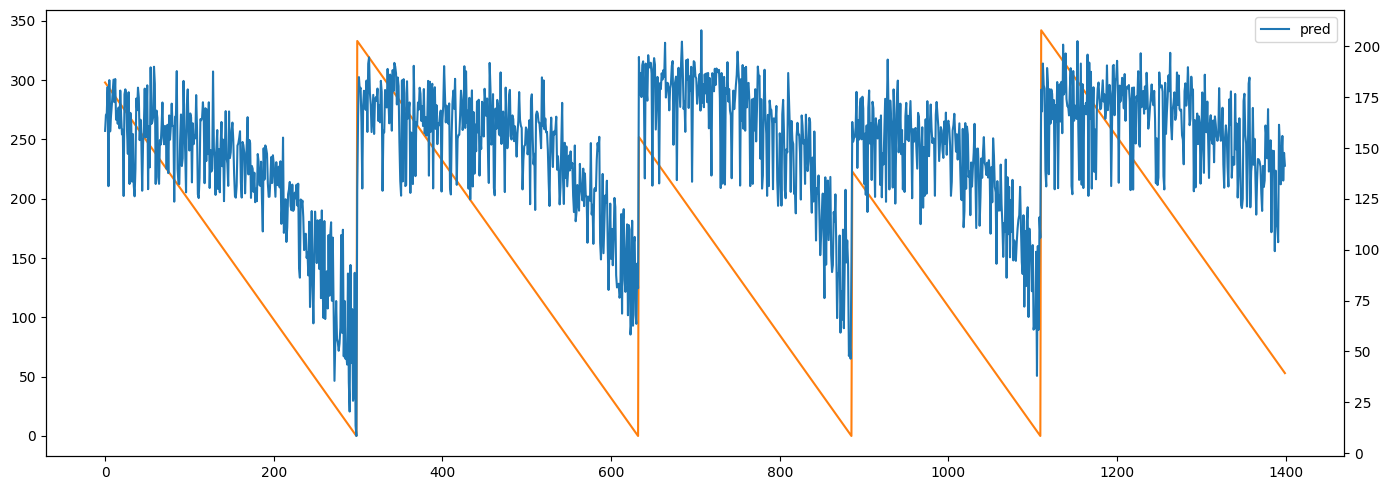

In [51]:
ts_pred = nn.predict(ts_s[dt_in]).ravel() * trmaxrul
stop = 1400
cst.plot_rul(ts_pred[:stop], ts["rul"].iloc[:stop], same_scale=False, figsize=figsize)

R2 score misura correlazione tra variabilità dei dati e correttezza del modello statistico utilizzato

In [52]:
#we use R2 score to assess the performance of the model in terms of variance explained by the model

tr_pred = nn.predict(ts_s[dt_in], verbose=0).ravel() * trmaxrul
print(f'R2 score: {r2_score(ts["rul"], tr_pred)}')

R2 score: 0.3796734031761213


Train the model (seed 1)

In [53]:
np.random.seed(1)
nn2 = cst.MLPRegressor(input_shape=len(dt_in), hidden=[32, 32])
nn2.compile(optimizer='Adam', loss='mse')
history = nn2.fit(trs_s[dt_in], trs_s['rul'], validation_split=0.2, batch_size=32, epochs=20, verbose=1)

Epoch 1/20
35/35 [==============================] - 1s 7ms/step - loss: 0.1099 - val_loss: 0.0133
Epoch 2/20
35/35 [==============================] - 0s 2ms/step - loss: 0.0150 - val_loss: 0.0139
Epoch 3/20
35/35 [==============================] - 0s 2ms/step - loss: 0.0122 - val_loss: 0.0127
Epoch 4/20
35/35 [==============================] - 0s 2ms/step - loss: 0.0111 - val_loss: 0.0132
Epoch 5/20
35/35 [==============================] - 0s 3ms/step - loss: 0.0108 - val_loss: 0.0106
Epoch 6/20
35/35 [==============================] - 0s 2ms/step - loss: 0.0097 - val_loss: 0.0111
Epoch 7/20
35/35 [==============================] - 0s 2ms/step - loss: 0.0094 - val_loss: 0.0184
Epoch 8/20
35/35 [==============================] - 0s 2ms/step - loss: 0.0092 - val_loss: 0.0124
Epoch 9/20
35/35 [==============================] - 0s 3ms/step - loss: 0.0085 - val_loss: 0.0130
Epoch 10/20
35/35 [==============================] - 0s 2ms/step - loss: 0.0078 - val_loss: 0.0097
Epoch 11/20
35/35 [

Evaluation on the test set

496/496 [==============================] - 1s 1ms/step


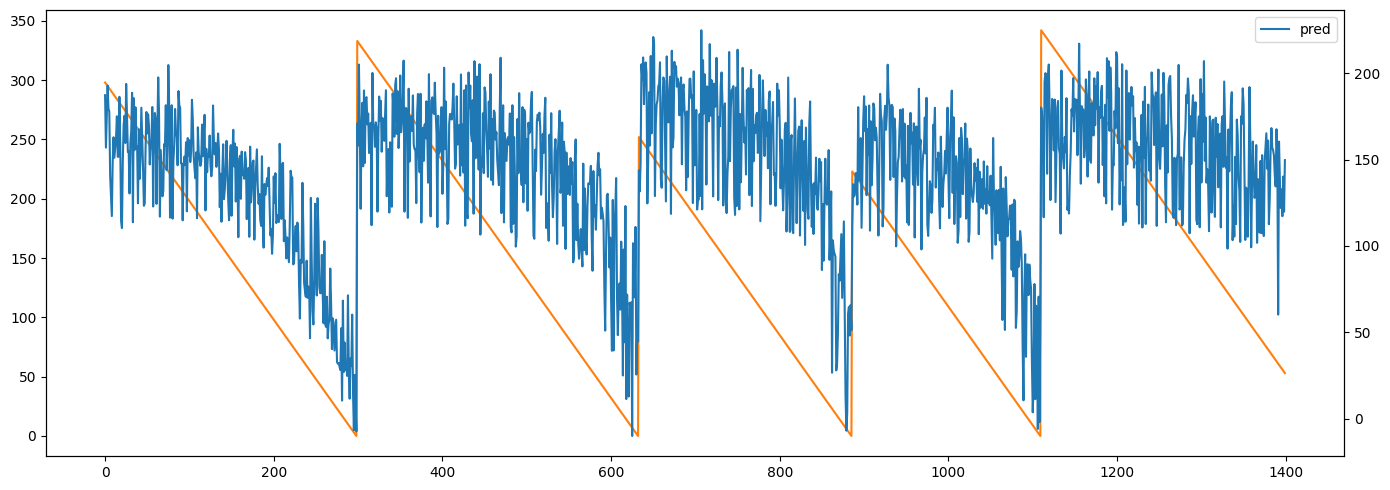

In [54]:
ts_pred = nn2.predict(ts_s[dt_in]).ravel() * trmaxrul
stop = 1400
cst.plot_rul(ts_pred[:stop], ts["rul"].iloc[:stop], same_scale=False, figsize=figsize)

In [55]:
#r2 score
tr_pred = nn2.predict(ts_s[dt_in], verbose=0).ravel() * trmaxrul
print(f'R2 score: {r2_score(ts["rul"], tr_pred)}')

R2 score: 0.38397877174891826


In [56]:
#Valuta il modello sui dati di test
y_pred_seed1 = nn.predict(ts_s[dt_in]) 
y_pred_seed2 = nn2.predict(ts_s[dt_in]) # Calcola le MSE di interesse
mse_seed1 = mean_squared_error(ts["rul"], y_pred_seed1) 
mse_seed2 = mean_squared_error(ts["rul"], y_pred_seed2) # Calcola la media e la deviazione standard delle MSE
mse_mean = np.mean([mse_seed1, mse_seed2]) 
mse_std = np.std([mse_seed1, mse_seed2]) 
print(f'Media della MSE: {mse_mean:.4f}')
print(f'Deviazione standard della MSE: {mse_std:.4f}')

496/496 [==============================] - 0s 824us/step
Media della MSE: 26618.6767
Deviazione standard della MSE: 1.0496


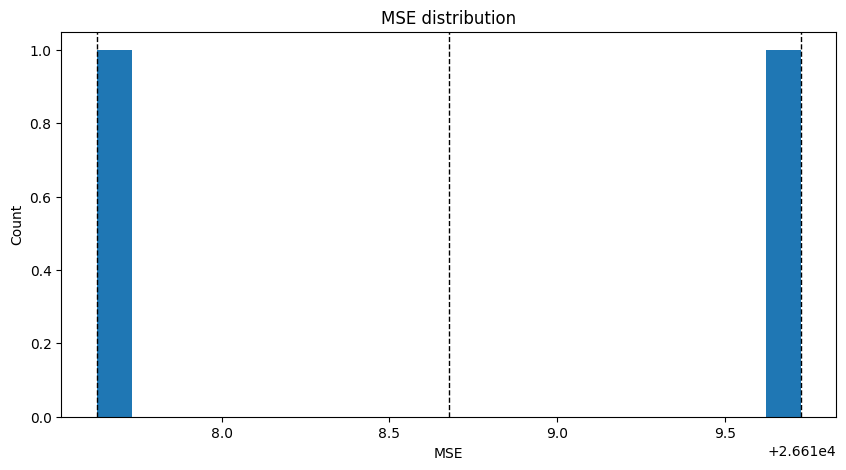

In [59]:
#plot a histogram with standard deviations and mean
plt.figure(figsize=(10, 5))
plt.hist([mse_seed1, mse_seed2], bins=20)
plt.axvline(mse_mean, color='k', linestyle='dashed', linewidth=1)
plt.axvline(mse_mean + mse_std, color='k', linestyle='dashed', linewidth=1)
plt.axvline(mse_mean - mse_std, color='k', linestyle='dashed', linewidth=1)
plt.xlabel('MSE')
plt.ylabel('Count')
plt.title('MSE distribution')
plt.show()

#### 1.2 75% of supervised data used for training

In [72]:
train_ratio = 0.75 # Ratio of supervised experiments
sep_trs = int(train_ratio * len(trs))

trs_2 = trs[:sep_trs]#prende 75% dei dati supervisionati

34038


34038

In [74]:
print(f'Num. samples: {len(trs_2)} (supervised), {len(ts)} (test)')

Num. samples: 34038 (supervised), 15864 (test)


#### 1.3 50% of supervised data used for training

## Evaluation

**The RUL Predictions follow the trend already identified**

...But they are much more noisy, due to the small size of the training set

43/43 [==============================] - 0s 479us/step


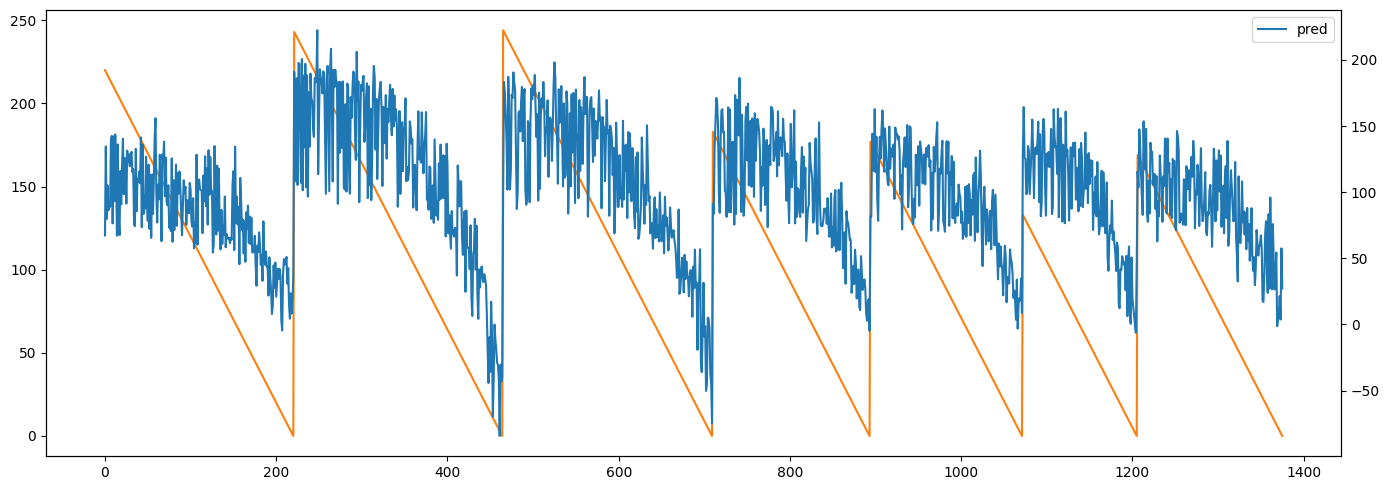

In [13]:
trs_pred = nn.predict(trs_s[dt_in]).ravel() * trmaxrul
stop = 1400 
cst.plot_rul(trs_pred[:stop], trs["rul"].iloc[:stop], same_scale=False, figsize=figsize)

## Evaluation

**The behavior on the unsupervised data is very similar**

...And similarly noisy

1376/1376 [==============================] - 1s 530us/step


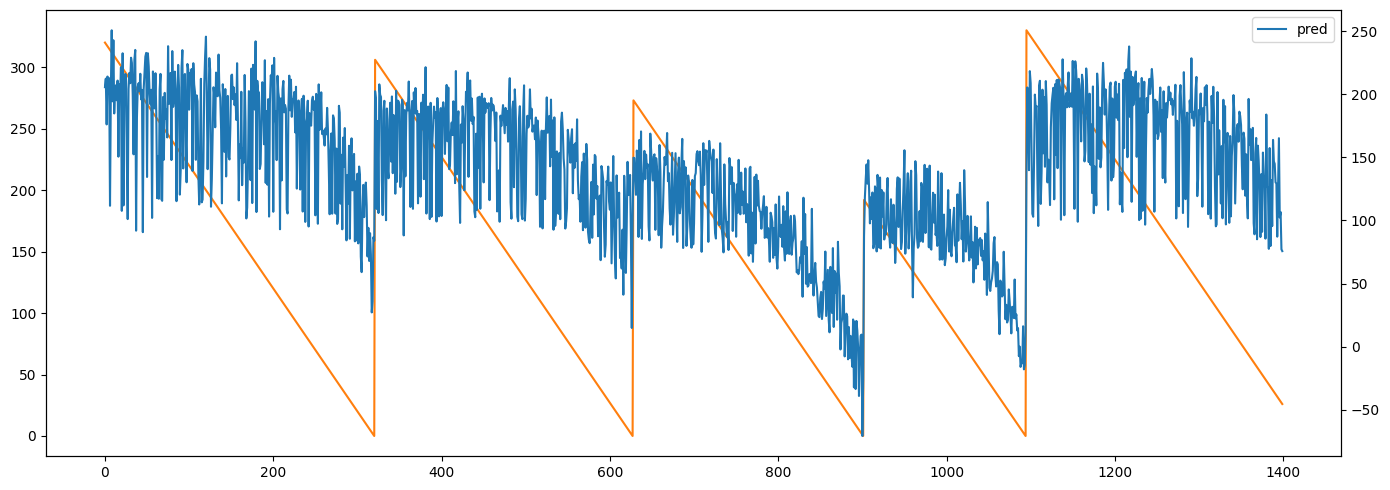

In [14]:
tru_pred = nn.predict(tru_s[dt_in]).ravel() * trmaxrul
cst.plot_rul(tru_pred[:stop], tru["rul"].iloc[:stop], same_scale=False, figsize=figsize)

## Evaluation

**The same goes for the data in the test set**

496/496 [==============================] - 0s 524us/step


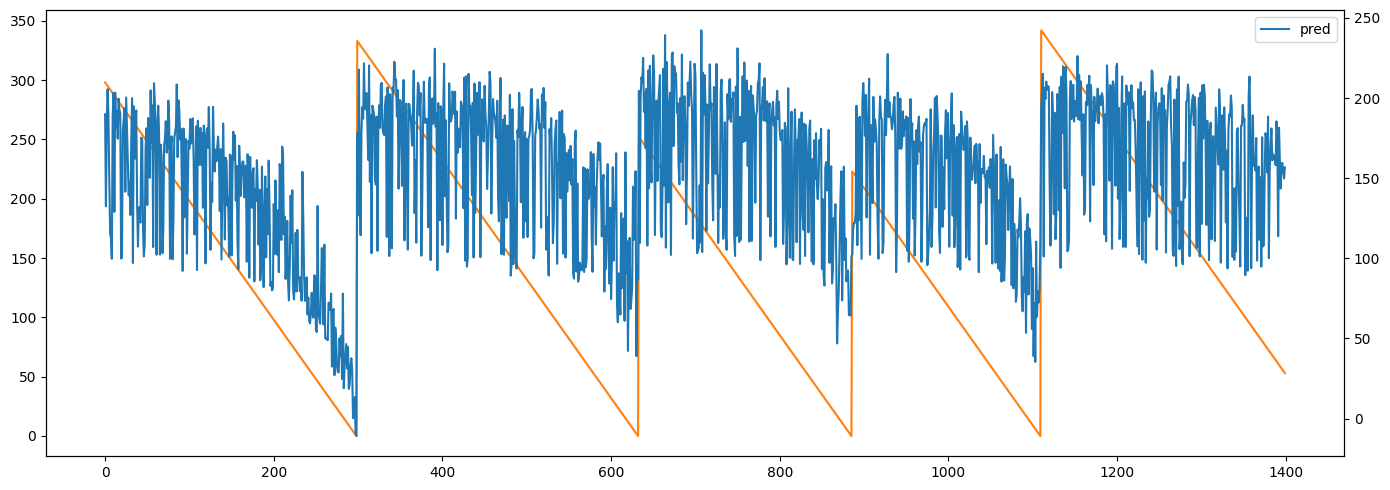

In [15]:
ts_pred = nn.predict(ts_s[dt_in]).ravel() * trmaxrul
cst.plot_rul(ts_pred[:stop], ts["rul"].iloc[:stop], same_scale=False, figsize=figsize)

## Cost Model and Threshold Optimization

**We then proceed to define a cost model**

Optimal threshold for the training set: 4


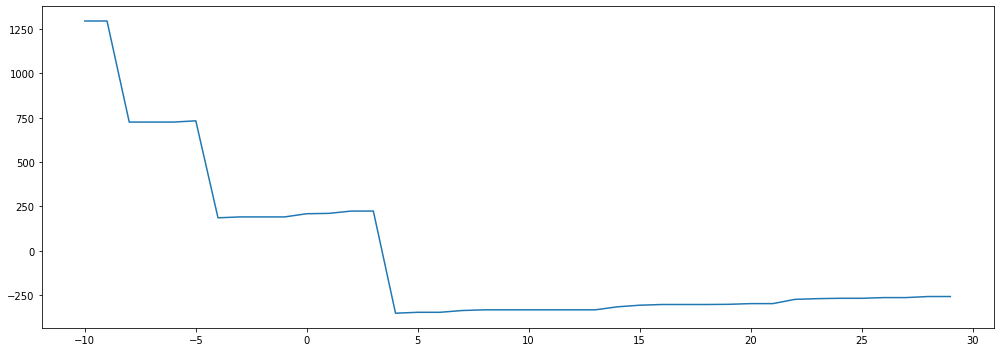

In [14]:
failtimes = dt.groupby('machine')['cycle'].max() 
safe_interval, maintenance_cost = failtimes.min(), failtimes.max()

cmodel = cst.RULCostModel(maintenance_cost=maintenance_cost, safe_interval=safe_interval)
th_range = np.arange(-10, 30)
trs_thr = cst.opt_threshold_and_plot(trs_s['machine'].values, trs_pred, th_range, cmodel, figsize=figsize)
print(f'Optimal threshold for the training set: {trs_thr}')

## Cost Results

**The cost on the training set is still good...**

...But that is not true for the unsupervised experiments and the test set

In [15]:
trs_c, trs_f, trs_sl = cmodel.cost(trs_s['machine'].values, trs_pred, trs_thr, return_margin=True)
tru_c, tru_f, tru_sl = cmodel.cost(tru_s['machine'].values, tru_pred, trs_thr, return_margin=True)
ts_c, ts_f, ts_sl = cmodel.cost(ts['machine'].values, ts_pred, trs_thr, return_margin=True)
print(f'Cost: {trs_c} (supervised), {tru_c} (unsupervised), {ts_c} (test)')

Cost: -352 (supervised), 34750 (unsupervised), 13408 (test)


In [16]:
trs_nm, tru_nm, ts_nm = len(trs_mcn), len(tru_mcn), len(ts_mcn)
print(f'Avg. fails: {trs_f/trs_nm:.2f} (supervised), {tru_f/tru_nm:.2f} (unsupervised), {ts_f/ts_nm:.2f} (test)')
print(f'Avg. slack: {trs_sl/trs_nm:.2f} (supervised), {tru_sl/tru_nm:.2f} (unsupervised), {ts_sl/len(ts_mcn):.2f} (test)')

Avg. fails: 0.00 (supervised), 0.43 (unsupervised), 0.46 (test)
Avg. slack: 18.29 (supervised), 11.08 (unsupervised), 9.83 (test)


* In particular, there is a _very high failure rate on unseen data_

# Domain Knowledge as Constraints

## Domain Knowledge as Constraints

**We know that the RUL _decreases at a fixed rate_**

* After 1 time step, the RUL will have decreased by 1 unit
* After 2 time steps, the RUL will have decreased by 2 units and so on

**In general, let $\hat{x}_i$ and $\hat{x}_j$ be the $i$-th and $j$-th samples _for a given component_**

Then we know that:

$$\begin{align}
& f(\hat{x}_i, \omega) - f(\hat{x}_j, \omega) = j - i & \forall i, j = 1..m \text{ s.t. } c_i = c_j
\end{align}$$

* $c_i, c_j$ are the components for (respectively) sample $i$ and $j$
* Samples are assumed to be _temporally sorted_
* The left-most terms is the difference between the predicted RULs
* $j -i$ is the difference between the sequential indexes of the two samples
* ...Which by construction should be equal to the RUL difference

## Domain Knowledge as Constraints

**The relation we identified is a _constraint_**

$$\begin{align}
& f(\hat{x}_i, \omega) - f(\hat{x}_j, \omega) = j - i & \forall i, j = 1..m \text{ s.t. } c_i = c_j
\end{align}$$

It represents domain knowledge that should (in principle) hold for our problem

* We don't need _strict satisfaction_: we can treat it as a _soft constraint_
* The constraint involves pairs of example, i.e. it is a _relational constraint_

**A simple approach: use the constraint to derive a _semantic regularizer_**

This approach is sometimes known as _Semantic Based Regularization_

* The regularizer represents a constraint that we think should generally hold
* ...It is meant to _assist the model_ by ensuring better generalization
* ...Or by speeding up the training process
* ...Or by allowing one to take advantage of (otherwise) unsupervised data


## Our Regularizer

**We need to design a regualizer for our constraint**

$$\begin{align}
& f(\hat{x}_i, \omega) - f(\hat{x}_j, \omega) = j - i & \forall i, j = 1..m \text{ s.t. } c_i = c_j
\end{align}$$

The regualizer should penalize violations of the constraint, e.g.
$$
\lambda \left(f(\hat{x}_i, \omega) - f(\hat{x}_j, \omega) - (j-i)\right)^2
$$

* Using the absolute value (h1 norm) may also work

**In principle, we should consider all valid pairs**

Such an approach would lead to the following loss function:
$$
L(\hat{x}, \omega) + \lambda \sum_{i=1..m} \sum_{\substack{j=i+1..m\\ c_i = c_j}} \left(f(\hat{x}_i, \omega) - f(\hat{x}_j, \omega) - (j-i)\right)^2
$$

* The $\lambda$ parameter balances the two loss terms

## Our Regularizer

**We can focus on contiguous pairs, i.e.**

$$
L(\hat{x}, \omega) + \lambda \sum_{\substack{i \prec j \\ c_i = c_j}} \left(f(\hat{x}_i, \omega) - f(\hat{x}_j, \omega) - (j-i)\right)^2
$$

* Where $i \prec j$ iff $j$ is the next sample for after $i$ for a given machine 
* This approach requires a linear (rather than quadratic) number of constraints

**It can work with mini-batches**

* In this case, $\prec$ will refer to contiguous samples _in the same batch_
* ...And of course for the same component

**We will now see how to implement this approach**

## Removing RUL Values

**We start by preparing a bit more the unsupervised data**

* First, we _remove the end_ of the unsupervised data sequences
* This simulate the fact that the machines are still operating

In [16]:
tru_s_by_m = cst.split_by_field(tru_s, 'machine')
np.random.seed(42)
for mcn, tmp in tru_s_by_m.items():
    cutoff = int(np.random.randint(10, 50, 1))
    tru_s_by_m[mcn] = tmp.iloc[:-cutoff]
tru_st = pd.concat(tru_s_by_m.values())

/tmp/ipykernel_11/2313383895.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cutoff = int(np.random.randint(10, 50, 1))


Then we assign an invalid value to the RUL for unsupervised data:

In [17]:
trsu_s = pd.concat((trs_s, tru_st))
trsu_s.loc[tru_st.index, 'rul'] = -1

We also buid a single dataset containing both supervised and unsupervised data

## Generating Batches from the Same Machine

**Our SBR approach requires to have _sorted_ samples _from the same machine_**

The easiest way to ensure we have enough of them is using a custom `DataGenerator`


```python
class SMBatchGenerator(tf.keras.utils.Sequence):
    def __init__(self, data, in_cols, batch_size, seed=42): ...

    def __len__(self): ...

    def __getitem__(self, index): ...

    def on_epoch_end(self): ...

    def __build_batches(self): ...
```

* `__len__` is called to know how many batches are left
* `__getitem__` should return one batch
* `on_epoch_end` should take care (e.g.) of shuffling

## Generating Batches from the Same Machine

**The `__init__` method takes care of the initial setup**

```python
def __init__(self, data, in_cols, batch_size, seed=42):
    super(SMBatchGenerator).__init__()
    self.data = data
    self.in_cols = in_cols
    self.dpm = split_by_field(data, 'machine')
    self.rng = np.random.default_rng(seed)
    self.batch_size = batch_size
    # Build the first sequence of batches
    self.__build_batches()
```

* We store some fields
* We split the data by machine
* We build a dedicated RNG
* ...And finally we call the custom-made `__build_batches` method

## Generating Batches from the Same Machine

**The `__build_batches` method prepares the batches for one full epoch**

```python
def __build_batches(self):
    self.batches, self.machines = [], []
    mcns = list(self.dpm.keys()) # sort the machines at random
    self.rng.shuffle(mcns)
    for mcn in mcns: # Loop over all machines
        index = self.dpm[mcn].index # sample indexes for this machine
        padsize = self.batch_size - (len(index) % self.batch_size)
        padding = self.rng.choice(index, padsize) # pad the last batch
        idx = np.hstack((index, padding))
        self.rng.shuffle(idx) # shuffle sample indexes for this machine
        bt = idx.reshape(-1, self.batch_size) # split into batches
        bt = np.sort(bt, axis=1) # sort every batch individually
        self.batches.append(bt) # store
        self.machines.append(np.repeat([mcn], len(bt)))
    self.batches = np.vstack(self.batches) # concatenate
    self.machines = np.hstack(self.machines)
```

## Generating Batches from the Same Machine

**A few other functions become very simple at this point**

```python
def __len__(self):
    return len(self.batches)

def on_epoch_end(self):
    self.__build_batches()
```

* `__len__` return the number of batches in the collection
* `__getitem__` simply retrieves one batch from the collection
* We rebuild the batches every epoch

## Generating Batches from the Same Machine

**Most of the remaining work is done in the `__getiitem__` method:**

```python
def __getitem__(self, index):
    idx = self.batches[index]
    x = self.data[self.in_cols].loc[idx].values
    y = self.data['rul'].loc[idx].values
    flags = (y != -1)
    info = np.vstack((y, flags, idx)).T
    return x, info
```

* We retrieve the sample indexes `idx` for the batch
* ...The the corresponding input and RUL values from `self.data`
* The RUL value is -1 for the unsupervised data: we flag the meaningful RULs
* ...We pack indexes, RUL values, and flags into a single `info` tensor

## Custom Training Step

**We then enforce the constraints by means of a _custom training step_**

```python
class CstRULRegressor(MLPRegressor):
    def __init__(self, input_shape, alpha, beta, hidden=[]): ...
        
    def train_step(self, data): ...

    @property
    def metrics(self): ...
```

* We subclass our `MLPRegressor`, so we share its model structure
* We also inherit its `call` method
* The custom training step is implemented in `train_step`
* The `metrics` property allows us to rely on keras metric tracking

## Custom Training Step

**In the `__init__` function:**

```python
def __init__(self, input_shape, alpha, beta, maxrul, hidden=[]):
    super(CstRULRegressor, self).__init__(input_shape, hidden)
    # Weights
    self.alpha = alpha
    self.beta = beta
    self.maxrul = maxrul
    # Loss trackers
    self.ls_tracker = keras.metrics.Mean(name='loss')
    self.mse_tracker = keras.metrics.Mean(name='mse')
    self.cst_tracker = keras.metrics.Mean(name='cst')
```

* `beta` is the regularizer weight, `alpha` is a weight for the loss function itself
  - `alpha=0,beta=1` corresponds to a fully unsupervised approach
* We also store the maximum RUL
* We build several "trackers" for the terms in our loss function

## Custom Training Step

**In the custom training step:**

```python
def train_step(self, data):
    x, info = data
    y_true = info[:, 0:1]
    flags = info[:, 1:2]
    idx = info[:, 2:3]

    with tf.GradientTape() as tape:
        y_pred = self(x, training=True) # predictions
        mse = k.mean(flags * k.square(y_pred-y_true)) # MSE loss
        delta_pred = y_pred[1:] - y_pred[:-1] # pred. difference
        delta_rul = -(idx[1:] - idx[:-1]) /self.maxrul # index difference
        deltadiff = delta_pred - delta_rul # difference of differences
        cst = k.mean(k.square(deltadiff)) # regualization term
        loss = self.alpha * mse + self.beta * cst # loss
    ...
```

* We unpack the `info` tensor
* Inside a `GradientTape`, we construct our regularized loss

## Custom Training Step

**In the custom training step:**

```python
def train_step(self, data):
    ...
    tr_vars = self.trainable_variables
    grads = tape.gradient(loss, tr_vars) # gradient computation

    self.optimizer.apply_gradients(zip(grads, tr_vars)) # weight update

    self.ls_tracker.update_state(loss) # update the loss trackers
    self.mse_tracker.update_state(mse)
    self.cst_tracker.update_state(cst)
    return {'loss': self.ls_tracker.result(), # return loss statuses
            'mse': self.mse_tracker.result(),
            'cst': self.cst_tracker.result()}
```

* We then apply the (Stochastic) Gradient Descent step
* Then we update and retun the loss trackers

## The SBR Approach: Fully Unsupervised Training

**We can now train our SBR-based approach**

We will make a first attempt with a pure unsupervised training:

In [25]:
nn2 = cst.CstRULRegressor(input_shape=len(dt_in), alpha=0, beta=1, maxrul=trmaxrul, hidden=[32, 32])
batch_gen = cst.CstBatchGenerator(trsu_s, dt_in, batch_size=32)
cb = [callbacks.EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)]
nn2.compile(optimizer='Adam', run_eagerly=False)
history = nn2.fit(batch_gen, epochs=20, verbose=1, callbacks=cb)

Epoch 1/20
1350/1350 [==============================] - 11s 8ms/step - loss: 0.0020 - mse: 0.0038 - cst: 0.0020
Epoch 2/20
1350/1350 [==============================] - 14s 10ms/step - loss: 5.1125e-04 - mse: 0.0013 - cst: 5.1125e-04
Epoch 3/20
1350/1350 [==============================] - 10s 7ms/step - loss: 4.4885e-04 - mse: 7.6831e-04 - cst: 4.4885e-04
Epoch 4/20
1350/1350 [==============================] - 15s 11ms/step - loss: 4.1754e-04 - mse: 4.6579e-04 - cst: 4.1754e-04
Epoch 5/20
1350/1350 [==============================] - 10s 8ms/step - loss: 4.0965e-04 - mse: 4.2318e-04 - cst: 4.0965e-04
Epoch 6/20
1350/1350 [==============================] - 6s 4ms/step - loss: 3.9508e-04 - mse: 4.7502e-04 - cst: 3.9508e-04
Epoch 7/20
1350/1350 [==============================] - 6s 4ms/step - loss: 3.8626e-04 - mse: 6.1249e-04 - cst: 3.8626e-04
Epoch 8/20
1350/1350 [==============================] - 14s 10ms/step - loss: 3.7855e-04 - mse: 7.2692e-04 - cst: 3.7855e-04
Epoch 9/20
1350/1350 [=

## Inspecting the Predictions

**Then let's check the predictions for the _test data_**

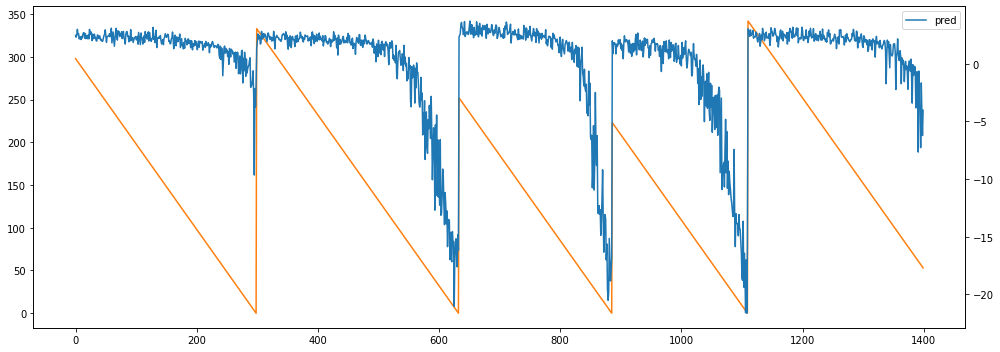

In [23]:
ts_pred = nn2.predict(ts_s[dt_in]).ravel() * trmaxrul
cst.plot_rul(ts_pred[:stop], ts["rul"].iloc[:stop], same_scale=False, figsize=figsize)

* In many cases, we are already obtaining the trend we are familiar with!
* The scale is however completely off

## The SBR Approach

**Let's try again using _both supervised and unsupervised data_:**

In [26]:
nn2 = cst.CstRULRegressor(input_shape=len(dt_in), alpha=1, beta=5, maxrul=trmaxrul, hidden=[32, 32])
batch_gen = cst.CstBatchGenerator(trsu_s, dt_in, batch_size=32)
cb = [callbacks.EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)]
nn2.compile(optimizer='Adam', run_eagerly=False)
history = nn2.fit(batch_gen, epochs=20, verbose=1, callbacks=cb)

Epoch 1/20
1350/1350 [==============================] - 6s 4ms/step - loss: 0.0060 - mse: 7.9022e-04 - cst: 0.0010
Epoch 2/20
1350/1350 [==============================] - 8s 6ms/step - loss: 0.0027 - mse: 4.4355e-04 - cst: 4.4750e-04
Epoch 3/20
1350/1350 [==============================] - 9s 6ms/step - loss: 0.0026 - mse: 4.4138e-04 - cst: 4.2749e-04
Epoch 4/20
1350/1350 [==============================] - 8s 6ms/step - loss: 0.0025 - mse: 4.3010e-04 - cst: 4.1182e-04
Epoch 5/20
1350/1350 [==============================] - 6s 5ms/step - loss: 0.0024 - mse: 4.3058e-04 - cst: 3.9663e-04
Epoch 6/20
1350/1350 [==============================] - 11s 8ms/step - loss: 0.0024 - mse: 4.3272e-04 - cst: 3.8564e-04
Epoch 7/20
1350/1350 [==============================] - 10s 7ms/step - loss: 0.0023 - mse: 4.2655e-04 - cst: 3.7846e-04
Epoch 8/20
1350/1350 [==============================] - 7s 5ms/step - loss: 0.0023 - mse: 4.1576e-04 - cst: 3.7353e-04
Epoch 9/20
1350/1350 [============================

## Inspecting the Predictions

**Let's have a look at the predictions on the _supervised_ data**

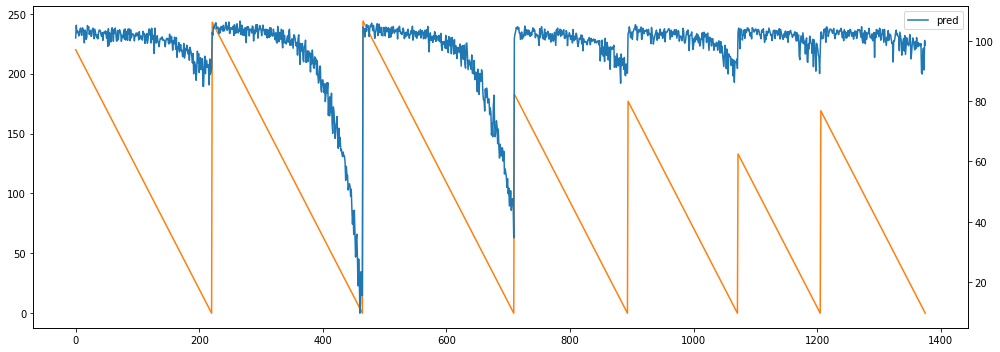

In [27]:
trs_pred = nn2.predict(trs_s[dt_in]).ravel() * trmaxrul
cst.plot_rul(trs_pred[:stop], trs["rul"].iloc[:stop], same_scale=False, figsize=figsize)

* The signal is _very stable_
* The scale is still off, but the approach will generally lead to overestimations
* ...However, we can fix that with a well chosen threshold

## Inspecting the Predictions

**Then let's do the same for the _unsupervised_ data**

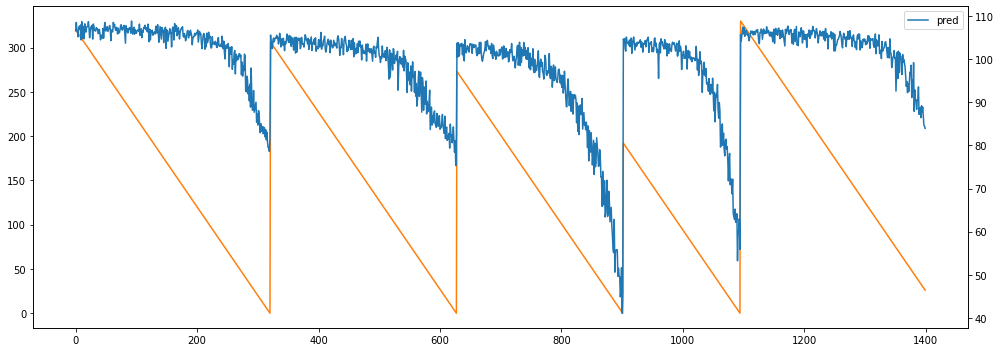

In [28]:
tru_pred = nn2.predict(tru_s[dt_in]).ravel() * trmaxrul
cst.plot_rul(tru_pred[:stop], tru["rul"].iloc[:stop], same_scale=False, figsize=figsize)

## Inspecting the Predictions

**Then let's do the same for the _test_ data**

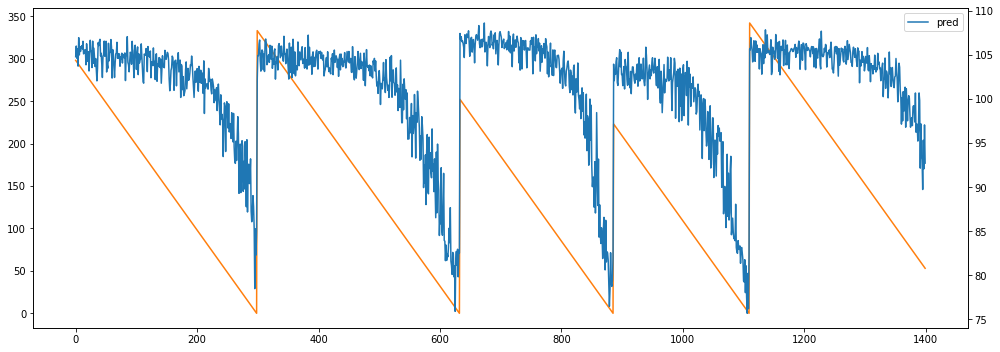

In [29]:
ts_pred = nn2.predict(ts_s[dt_in]).ravel() * trmaxrul
cst.plot_rul(ts_pred[:stop], ts["rul"].iloc[:stop], same_scale=False, figsize=figsize)

The behavior is more stable and consistent than before

## Threshold Optimization and Cost Evaluation

**We can now optimize the threshold (on the supervised data)**

Optimal threshold for the training set: 90


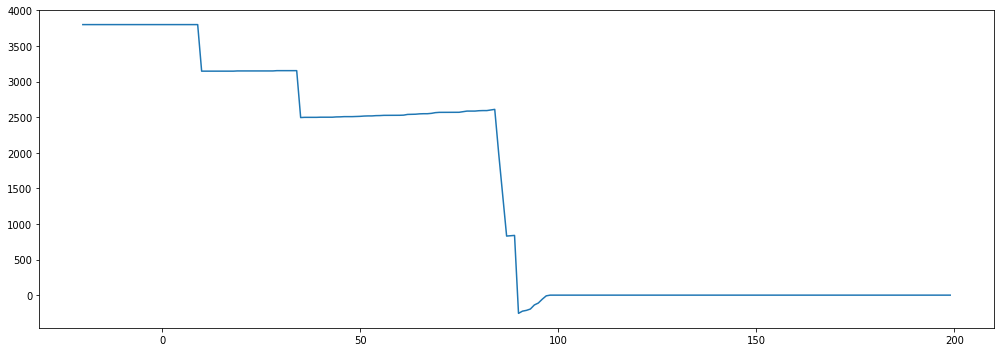

In [30]:
cmodel = cst.RULCostModel(maintenance_cost=maintenance_cost, safe_interval=safe_interval)
th_range = np.arange(-20, 200)
trs_thr = cst.opt_threshold_and_plot(trs_s['machine'].values, trs_pred, th_range, cmodel, figsize=figsize)
print(f'Optimal threshold for the training set: {trs_thr}')

## Threshold Optimization and Cost Evaluation

**Finally, we can evaluate the SBR approach in terms of cost**

In [31]:
trs_c, trs_f, trs_sl = cmodel.cost(trs_s['machine'].values, trs_pred, trs_thr, return_margin=True)
tru_c, tru_f, tru_sl = cmodel.cost(tru_s['machine'].values, tru_pred, trs_thr, return_margin=True)
ts_c, ts_f, ts_sl = cmodel.cost(ts['machine'].values, ts_pred, trs_thr, return_margin=True)
print(f'Cost: {trs_c} (supervised), {tru_c} (unsupervised), {ts_c} (test)')

Cost: -256 (supervised), -7092 (unsupervised), -2275 (test)


In [32]:
print(f'Avg. fails: {trs_f/len(trs_mcn):.2f} (supervised), {tru_f/len(tru_mcn):.2f} (unsupervised), {ts_f/len(ts_mcn):.2f} (test)')
print(f'Avg. slack: {trs_sl/len(trs_mcn):.2f} (supervised), {tru_sl/len(tru_mcn):.2f} (unsupervised), {ts_sl/len(ts_mcn):.2f} (test)')

Avg. fails: 0.00 (supervised), 0.07 (unsupervised), 0.08 (test)
Avg. slack: 32.29 (supervised), 39.12 (unsupervised), 41.62 (test)


* The number of fails has decreased very significantly
* The slack is still contained

And we did this with just a handful of run-to-failure experiments

## Considerations

**Regularized approaches for knowledge injection are very versatile**

They work as long as we have a good _differentiable regularizer_

* E.g. negative labels (here we assume a one-hot encoding for the output)
  * Constraint: $\mathit{round}(f_j(\hat{x}_i)) \neq 1$
  * A possbible regularizer: $f_j(\hat{x}_i)$
* E.g. subclass-class relations in multiclass classification
  * Constraint: $\mathit{round}(f_j(\hat{x}_i)) \Rightarrow \mathit{round}(f_k(\hat{x}_i))$ if $j$ is a subclass of $k$
  * A possible regularizer: $\max\left(0, f_j(\hat{x}_i) - f_k(\hat{x}_i)\right)$
* E.g. logical formulas can be translated into regularizers by mean of fuzzy logic

**Choosing the correct regularizer weight can be complicated**

* Since the is still improving generalization, we could use a validation set
* However, if supervised data is scarce this may not be practical
* In general: an open research problem

## Considerations

**Domain knowledge is ubiquitous**

* It is sometimes contrasted with deep learning
* ...But isn't it better to use both?


**Differentiability may be an issue**

* Some constraints are not naturally differentiable
* E.g. say we know that the (binary) classes are roughly balanced
  - The constraint: $\sum_{i=1}^m \mathit{round}(f(\hat{x}_i)) = m/2$
  - A possible regularizer: $\left(\sum_{i=1}^m f(\hat{x}_i) - m/2\right)^2$
* The penalty can be minimized by balancing the classes...
* ...But also by predicting 0.5 (complete uncertainty) for all examples!
* This is another open research issue